# Data description & Problem statement: 
   The dataset is related with a mortgage loan and challenge is to predict approval status of loan (Approved/Reject). Needless to mention that, among all industries, the insurance domain has one of the largest uses of analytics & data science methods. 
* Dataset is imbalanced. The data has 615 rows and 13 columns.
* This is a classification problem. I will predict if a loan will get approved or not.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc. 
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Cross-validation of Logistic Regression model with L1 regularization
- Cross-validation of Logistic Regression model with L2 regularization
- Use grid-search along with C-V approach to find the best hyperparameters of Logistic Regression model with both L1 & L2 regularizations: Find the best LR model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best LR model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score:  0.81 
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision:  0.92

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Loan prediction/train_loanPrediction.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)

df.drop('Loan_ID', axis=1, inplace=True)

L_c=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status' ]
L_n=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

df.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
df_selected=df[['Credit_History', 'ApplicantIncome', 'LoanAmount', 'CoapplicantIncome' , 'Property_Area', 'Loan_Status']]

df_selected.dropna( axis=0, inplace=True)

In [5]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

for i in [ 'Property_Area', 'Loan_Status' ]:
    encode_text_index(df_selected, i)
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

for i in ['Credit_History' , 'Property_Area']:
    encode_text_dummy(df_selected, i)
    
df_selected.head(3)

,ApplicantIncome,LoanAmount,CoapplicantIncome,Loan_Status,Credit_History-0.0,Credit_History-1.0,Property_Area-0,Property_Area-1,Property_Area-2
1,4583,128.0,1508.0,0,0,1,1,0,0
2,3000,66.0,0.0,1,0,1,0,0,1
3,2583,120.0,2358.0,1,0,1,0,0,1


In [6]:
X=df_selected.drop(['Loan_Status'], axis=1)
y=df_selected['Loan_Status']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

remove_outliers(X_train, y_train, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], thresh=4)

number of outliers removed :   13


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

scalor_X=MinMaxScaler().fit(X_train)
X_train=scalor_X.transform(X_train)
X_test=scalor_X.transform(X_test)

Max. Lasso score =  0.7904684190721927


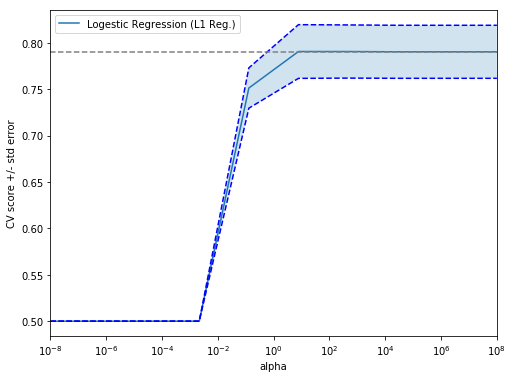

In [8]:
# Cross-Validation for Logestic Regression algorithm: L1 Regularization (Lasso model)
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression(penalty='l1', random_state=42)
C = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds=5
kfold= StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for c in C:
    model.C = c
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Lasso score = ", np.max(scores))


plt.figure().set_size_inches(8, 6)
plt.semilogx(C, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(C, scores + std_error, 'b--')
plt.semilogx(C, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(C, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([C[0], C[-1]])
plt.legend(['Logestic Regression (L1 Reg.)'])
plt.show()

Max. Lasso score =  0.7937971294952427


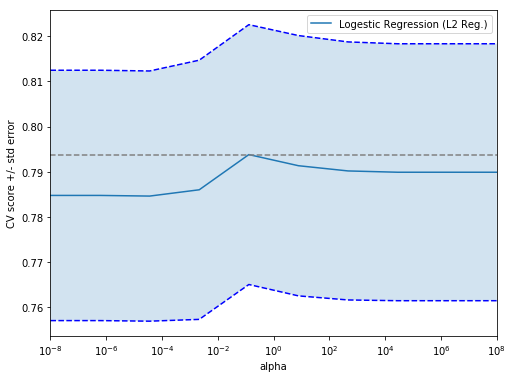

In [9]:
# Cross-Validation for Logestic Regression algorithm: L2 Regularization (Ridge model)
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model = LogisticRegression(penalty='l2', random_state=42)
C = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds=5
kfold= StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

for c in C:
    model.C = c
    this_scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

print("Max. Lasso score = ", np.max(scores))

plt.figure().set_size_inches(8, 6)
plt.semilogx(C, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(C, scores + std_error, 'b--')
plt.semilogx(C, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(C, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([C[0], C[-1]])
plt.legend(['Logestic Regression (L2 Reg.)'])
plt.show()

In [10]:
# Grid-Search for the best model parameters: 
from sklearn.model_selection import GridSearchCV

param=[{'penalty':['l2'], 'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 1000, 5000, 1e5]} ,
       {'penalty':['l1'], 'C': [0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 1000, 5000, 1e5]}]

# Resampling:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

#X_r, y_r=X_train, y_train
X_r, y_r = SMOTE(random_state=42, kind='svm').fit_sample(X_train, y_train)
#X_r, y_r = RandomOverSampler(random_state=42).fit_sample(X_train, y_train)


kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search=GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param, cv=kfold, scoring="roc_auc")
grid_search.fit(X_r, y_r)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_).sort_values("rank_test_score")
G.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
23,0.008439,0.003231,0.001057,0.002113,50,l1,"{'C': 50, 'penalty': 'l1'}",0.808985,0.751372,0.806693,...,0.806285,0.039413,1,0.815381,0.817893,0.808433,0.796380,0.811599,0.809937,0.007507
22,0.006073,0.007162,0.000199,0.000399,20,l1,"{'C': 20, 'penalty': 'l1'}",0.809671,0.751372,0.805981,...,0.806283,0.039277,2,0.815226,0.817937,0.808062,0.795987,0.811053,0.809653,0.007628
9,0.000200,0.000399,0.002926,0.005853,50,l2,"{'C': 50, 'penalty': 'l2'}",0.809671,0.750343,0.806337,...,0.806216,0.039689,3,0.815270,0.817430,0.808127,0.796292,0.811403,0.809705,0.007429


In [11]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'C': 50, 'penalty': 'l1'}
Best validation accuracy:  0.81 (+/- 0.04)
Test score:  0.81


Confusion matrix, without normalization
[[22 14]
 [17 83]]
Normalized confusion matrix
[[0.61 0.39]
 [0.17 0.83]]


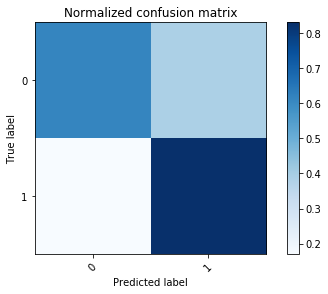

In [12]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)


# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [13]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.56      0.61      0.59        36
          1       0.86      0.83      0.84       100

avg / total       0.78      0.77      0.77       136



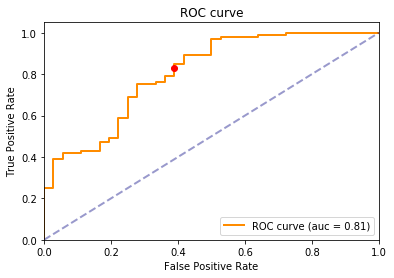

In [14]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test),grid_search.predict_proba(X_test)[:, 1] , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.predict_proba(X_test)[:, 1])

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

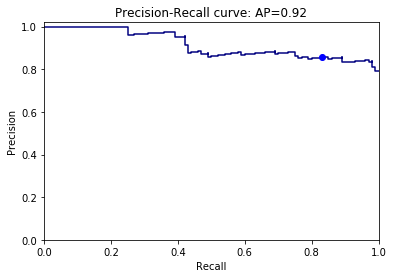

In [15]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(np.array(X_test))[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(np.array(X_test))[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()